In [7]:
# import the libraries
# https://github.com/chembl/notebooks/blob/main/ChEMBL_webresource_client_examples.ipynb
from chembl_webresource_client.new_client import new_client
from IPython.display import SVG
import requests
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools, rdRGroupDecomposition, Descriptors
from rdkit.Chem import Draw
from rdkit import DataStructs, rdBase
import platform
print('python version: ' + platform.python_version())
print(f'rdkit version: {rdBase.rdkitVersion}')

python version: 3.10.6
rdkit version: 2022.03.5


### APIで化合物情報を取得

In [2]:
activities = new_client.activity.filter(
    target_chembl_id__in=[
        'CHEMBL5552',
        # 'CHEMBL1075195'
        ],  ##Specify a list of example targets (#Serine/threonine-protein kinase 25 (STK25) & Serine-threonine kinases TAO2)
    pchembl_value__gte=5,  ##Specify a minimum threshold of the pChEMBL activity value. Note that pCHEMBL = -log10(IC50, XC50, AC50, Ki, Kd, potency). Greater than or equal to 5 (10um) is a typical minimum rule of thumb for binding activity between a compound and a protein target. 
    assay_type='B',  ##Only look for Binding Assays
).only([
    'molecule_chembl_id',
    'molecule_pref_name',
    'target_chembl_id',
    'target_pref_name',
    'parent_molecule_chembl_id',
    'pchembl_value',
    'canonical_smiles',
    'assay_description',
    'document_chembl_id',
    'document_journal',
    'document_year',
]) ## Specify which fields (columns) to extract  


df = pd.DataFrame(activities)

# Mol File 追加
PandasTools.AddMoleculeColumnToFrame(df, 'canonical_smiles', 'Molecule', includeFingerprints=True)
# Murcko Scaffoldの追加
PandasTools.AddMurckoToFrame(df, molCol='Molecule', MurckoCol='Murcko_SMILES')
PandasTools.AddMurckoToFrame(df, molCol='Molecule', MurckoCol='Murcko_generic_SMILES', Generic=True)
PandasTools.AddMoleculeColumnToFrame(df, molCol='Murcko_Mol', smilesCol='Murcko_SMILES')
PandasTools.AddMoleculeColumnToFrame(df, molCol='Murcko_generic_Mol', smilesCol='Murcko_generic_SMILES')
# PandasTools.FrameToGridImage(df[:8], column='Murcko_generic_Mol', legendsCol=None, molsPerRow=4)

# 文献数
print("the number of Document ChEMBL ID is " + str(len(df['document_chembl_id'].unique())))

# 骨格数情報 SMILESじゃないとなぜか反映されない
print("the number of Murcko generic scaffold is " + str(len(df['Murcko_generic_SMILES'].unique())))
print("the number of Murcko scaffold is " + str(len(df['Murcko_SMILES'].unique())))

# descriptorの追加
df['MW'] = df['canonical_smiles'].apply(lambda x : Descriptors.MolWt(Chem.MolFromSmiles(x)))
df['Mol LogP'] = df['canonical_smiles'].apply(lambda x : Descriptors.MolLogP(Chem.MolFromSmiles(x)))
df['TPSA'] = df['canonical_smiles'].apply(lambda x : Descriptors.TPSA(Chem.MolFromSmiles(x)))
df['Ct HA'] = df['canonical_smiles'].apply(lambda x : Descriptors.HeavyAtomCount(Chem.MolFromSmiles(x)))
df['Ct F'] = df['canonical_smiles'].apply(lambda x : x.count('F'))
df['HBD'] = df['canonical_smiles'].apply(lambda x : Descriptors.NumHDonors(Chem.MolFromSmiles(x)))
df['HBA'] = df['canonical_smiles'].apply(lambda x : Descriptors.NumHAcceptors(Chem.MolFromSmiles(x)))
df['Ct RB'] = df['canonical_smiles'].apply(lambda x : Descriptors.NumRotatableBonds(Chem.MolFromSmiles(x)))
df['Ct Ar'] = df['canonical_smiles'].apply(lambda x : Descriptors.NumAromaticRings(Chem.MolFromSmiles(x)))


# molecule = new_client.molecule
# mols = molecule.filter(pref_name__iexact='aspirin')
# df = pd.DataFrame(mols)
# df

the number of Document ChEMBL ID is 8
the number of Murcko generic scaffold is 24
the number of Murcko scaffold is 24


In [3]:
dfd = df.groupby(['document_year'])['document_chembl_id'].describe()
dfm = df.groupby(['document_year'])['Murcko_generic_SMILES'].describe()
dfg = df.groupby(['document_chembl_id'])['Murcko_generic_SMILES'].describe()

##### Count Documents and Scaffolds by Year

In [4]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(x=dfd.index, y=dfd['unique'], name='Document count'))
fig.add_trace(go.Bar(x=dfm.index, y=dfm['unique'], name='Scaffold count'))

fig.update_layout(
    title='Murcko generic scaffold v.s. Year',
    # showlegend=False, # Legendのon/off
    width=1000,
    # height=700
    barmode='group',
)
fig.show()

In [35]:
df['AddHs'] = df['Molecule'].apply(lambda x : AllChem.AddHs(x))
df['3D'] = df['AddHs'].apply(lambda x : AllChem.EmbedMolecule(x, AllChem.ETKDGv3()))
df['NPR1'] = df['AddHs'].apply(lambda x : Descriptors3D.NPR1(x))
df['NPR2'] = df['AddHs'].apply(lambda x : Descriptors3D.NPR2(x))
df['3D'] = df['AddHs'].apply(lambda x : AllChem.RemoveHs(x))


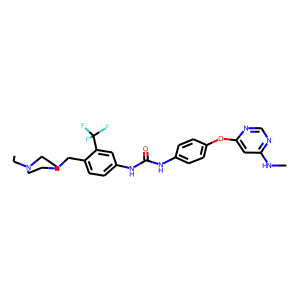

In [39]:
Draw.MolToImage(df['3D'].iloc[0])

In [31]:
import plotly.express as px
fig = px.scatter(df,
    x='NPR1',
    y='NPR2',
    # color='Molecule Max Phase',
    # color='AlogP',
    # color='Document ChEMBL ID',
    # color='Murcko_generic_SMILES',
    # size='pChEMBL Value',
    # hover_name='Molecule ChEMBL ID',
    # hover_data=['Document ChEMBL ID', df.index],
    opacity=0.5
)
fig.update_layout(
    title='LLE v.s. MW',
    # showlegend=False, # Legendのon/off
    width=600,
    # height=700,
    xaxis=dict(range= (0,1))
) 
fig.update_xaxes
fig.show()


In [34]:
import plotly.express as px
fig = px.scatter_3d(df,
                    x='PMI1',
                    z='PMI2',
                    y='PMI3',
                    # color='Document ChEMBL ID',
                    # color='Murcko_generic_SMILES',
                    # size='pChEMBL Value',
                    # hover_name='Molecule ChEMBL ID',
                    # hover_data=['Molecule ChEMBL ID',df.index],
                    opacity=0.5
                    )
fig.update_layout(
    # showlegend=False, # Legendのon/off
    width=500,
    height=500,
    xaxis=dict(range= (0,1))
    ) 
fig.show()